# Indentificando fraude a partir de e-mails da Enron

#### Udacity - Introdução a Machine Learning


## Enron Corporation

>A Enron Corporation foi uma companhia de energia americana, localizada em Houston, Texas. Empregava cerca de 21 000 pessoas, tendo sido uma das empresas líderes no mundo em distribuição de energia (electricidade, gás natural) e comunicações, mas decretou falência. Seu faturamento atingia 101 bilhões de dólares em 2000, pouco antes do escândalo financeiro que ocasionou sua falência.

>Alvo de diversas denúncias de fraudes contábeis e fiscais e com uma dívida de 13 bilhões de dólares, o grupo pediu concordata em dezembro de 2001 e arrastou consigo a Arthur Andersen, que fazia a sua auditoria. Na época, as investigações revelaram que a Enron havia manipulado seus balanços , com a ajuda de empresas e bancos, e escondera dívidas de 25 bilhões de dólares por dois anos consecutivos, tendo inflado artificialmente os seus lucros.

>O governo dos Estados Unidos abriu dezenas de investigações criminais contra executivos da Enron e da Arthur Andersen. A Enron foi também processada pelas pessoas lesadas. De acordo com os investigadores, os executivos e contadores, assim como instituições financeiras e escritórios de advocacia, que à época trabalhavam para a companhia, foram, de alguma forma e em diferentes graus, responsáveis pelo colapso da empresa.
>Em razão de uma série de escândalos financeiros corporativos, como o da Enron, foi redigida a lei Sarbanes-Oxley, em 2002.

>O ocorrido serviu de palco para o filme de comédia As Loucuras de Dick & Jane (2005) Com Jim Carrey, onde ele trabalha na Globodyne (Fictícia Enron) e passa altos perrengues devido a falência da empresa. Vale notar um EasterEgg no final, onde seu vizinho ostentador se gaba por ter conseguido um emprego na incrível Enron.

[wikipedia](https://pt.wikipedia.org/wiki/Enron)







## Visão Geral do Projeto

Neste projeto, irei bancar o detetive, e construirei um modelo de machine learning que visará determinar se um funcionário é ou não uma Person Of Interest  (POI). Um POI é um funcionário que participou do escândalo da Enron. Os dados são uma combinação de dados financeiros e dados de e-mails dos funcionários investigados neste caso de fraude, o que significa que eles foram indiciados, fecharam acordos com o governo, ou testemunharam em troca de imunidade no processo.




## Etapas para o Sucesso

Como etapa de pré-processamento deste projeto, foi combinado os dados da base "Enron email and financial" em um dicionário, onde cada par chave-valor corresponde a uma pessoa. A chave do dicionário é o nome da pessoa, e o valor é outro dicionário, que contém o nome de todos os atributos e seus valores para aquela pessoa. O dataset possue basicamente três tipos: atributos financeiros, de email e rótulos POI (pessoa de interesse).

**atributos financeiros:** ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (todos em dólares americanos (USD))

**atributos de email:** ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']     (as unidades aqui são geralmente em número de emails; a exceção notável aqui é o atributo ‘email_address’, que é uma string)

**rótulo POI:** [‘poi’] (atributo objetivo lógico (booleano), representado como um inteiro)

### Processo de construção e treinamento do modelo

A construção do modelo preditivo seguirá um procecesso geral com as fases abaixo:

   1. **Explorar os dados:** as fases podem, em alguns momentos, ser intercaladas entre si:
           - Explorar as características dos dados.
           - Explorar os dados estatisticamente.
           - Identificar valores ausentes.
           - Identificar ruídos nos dados(outliers).
           - Explorar os dados visualmente.
           - Estudar as distribuições dos atributos.
           - Estudar possíveis correlações entre os atributos.
   2. **Preparar os dados:**           
           - Fixar ou remover ruídos.           
           - Engenharia de atributos.
           - Seleção de características(atributos)    
           - Preencher valores ausentes(com média, zero...) ou removê-los.
   3. **Escolha e Afinamento de um Modelo:**
           1. Treinar uma variedade de classificadores.
           2. Medir e comparar as performances.
           3. Selecionar um modelo.
           4. Afinar e Tunar o modelo.
   4. **Avaliar e Validar:**
           1. Feita em paralelo com a fase anterior.

## Importando as bibliotecas e os dados

In [2]:
import sys
import pickle
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
sys.path.append("tools/")
warnings.filterwarnings(action='ignore')
# ================================================== #
#               Classifiers                          #
# ================================================== #
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# ================================================== #
#               Scaler and feature selection         #
# ================================================== #
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from feature_format import featureFormat, targetFeatureSplit
# ================================================== #
#               Validation and Test                  #
# ================================================== #
from sklearn import cross_validation
from tester import dump_classifier_and_data
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split
from tester import dump_classifier_and_data, test_classifier
from sklearn.metrics import recall_score, precision_score, f1_score
# ===================================================#
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from time import time

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    


att_financial =  ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 
                    'bonus',  'restricted_stock_deferred', 'deferred_income', 
                    'total_stock_value', 'expenses', 'exercised_stock_options', 
                    'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

att_email =  ['to_messages', 'email_address', 'from_poi_to_this_person', 
              'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

# ================================================== #
#               Helper Functions                     #
# ================================================== #
def draw_scatter(dictionary, features):
    """Cria um scatterplot com destaque nos POIs se existir.
    
    """
    data = featureFormat(dictionary, features)
    for point in data:
        is_poi = bool(point[0])
        axis_x = point[1]
        axis_y = point[2]
        if is_poi:
            plt.scatter(axis_x, axis_y, 100, color="r", marker=".", alpha=.4)
        else:
            plt.scatter(axis_x, axis_y, 100, color="b", marker=".", alpha=.4)
  
    plt.xlabel(features[1])
    plt.ylabel(features[2])
    plt.show()

Populating the interactive namespace from numpy and matplotlib


# Fase 1: Explorar os dados

Para maior facilidade na exploração dos dados, irei converter o dicionário em um dataframe do pandas.

In [3]:
df = pd.DataFrame.from_records(data_dict).T.reset_index().rename({'index': 'nome'}, axis=1)
df.replace(to_replace='NaN', value=numpy.nan, inplace=True)

## Explorar as características dos dados

### Tamanho do dataset

In [24]:
print 'Existem %d pessoas no dataset' % len(df)

Existem 146 pessoas no dataset


### Nome das colunas

In [30]:
df.columns

Index([u'nome', u'bonus', u'deferral_payments', u'deferred_income',
       u'director_fees', u'email_address', u'exercised_stock_options',
       u'expenses', u'from_messages', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive',
       u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred',
       u'salary', u'shared_receipt_with_poi', u'to_messages',
       u'total_payments', u'total_stock_value'],
      dtype='object')

### Tipos dos dados

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
nome                         146 non-null object
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                111 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null bool
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt

### Dados ausentes

In [33]:
pd.isnull(df).sum()

nome                           0
bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                 35
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64

Podemos perceber que existem atributos com muitos valores ausentes como, por exemplo, 'loan_advances'com 142, 'restricted_stock_deferred' com 128, 'director_fees' com 129 e 'deferral_payments' com 107. Nesse momento do projeto eu ainda não sei dizer o nível de importância desses atributos, mas se não forem muito importantes, já temos ótimos candidatos para serem descartados.

### Amostra dos dados

In [47]:
df.head()

,nome,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,NaN,phillip.allen@enron.com,1729541.0,13868.0,2195.0,47.0,...,304805.0,152.0,False,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
1,BADUM JAMES P,NaN,178980.0,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466.0,257817.0
2,BANNANTINE JAMES M,NaN,NaN,-5104.0,NaN,james.bannantine@enron.com,4046157.0,56301.0,29.0,39.0,...,NaN,864523.0,False,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
3,BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,NaN,6680544.0,11200.0,NaN,NaN,...,1586055.0,2660303.0,False,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0
4,BAY FRANKLIN R,400000.0,260455.0,-201641.0,NaN,frank.bay@enron.com,NaN,129142.0,NaN,NaN,...,NaN,69.0,False,145796.0,-82782.0,239671.0,NaN,NaN,827696.0,63014.0


In [48]:
df.tail()

,nome,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
141,WINOKUR JR. HERBERT S,NaN,NaN,-25000.0,108579.0,NaN,NaN,1413.0,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,84992.0,NaN
142,WODRASKA JOHN,NaN,NaN,NaN,NaN,john.wodraska@enron.com,NaN,NaN,NaN,NaN,...,NaN,189583.0,False,NaN,NaN,NaN,NaN,NaN,189583.0,NaN
143,WROBEL BRUCE,NaN,NaN,NaN,NaN,NaN,139130.0,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,139130.0
144,YEAGER F SCOTT,NaN,NaN,NaN,NaN,scott.yeager@enron.com,8308552.0,53947.0,NaN,NaN,...,NaN,147950.0,True,3576206.0,NaN,158403.0,NaN,NaN,360300.0,11884758.0
145,YEAP SOON,NaN,NaN,NaN,NaN,NaN,192758.0,55097.0,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,55097.0,192758.0


## Explorar os dados estatisticamente

### Visão estatística do dataset completo

In [49]:
df.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.200000e+01,3.900000e+01,4.900000e+01,1.700000e+01,1.020000e+02,9.500000e+01,86.000000,86.000000,86.000000,4.000000e+00,6.600000e+01,9.300000e+01,1.100000e+02,1.800000e+01,9.500000e+01,86.000000,86.000000,1.250000e+02,1.260000e+02
mean,2.374235e+06,1.642674e+06,-1.140475e+06,1.668049e+05,5.987054e+06,1.087289e+05,608.790698,64.895349,41.232558,4.196250e+07,1.470361e+06,9.190650e+05,2.321741e+06,1.664106e+05,5.621943e+05,1176.465116,2073.860465,5.081526e+06,6.773957e+06
std,1.071333e+07,5.161930e+06,4.025406e+06,3.198914e+05,3.106201e+07,5.335348e+05,1841.033949,86.979244,100.073111,4.708321e+07,5.942759e+06,4.589253e+06,1.251828e+07,4.201494e+06,2.716369e+06,1178.317641,2582.700981,2.906172e+07,3.895777e+07
min,7.000000e+04,-1.025000e+05,-2.799289e+07,3.285000e+03,3.285000e+03,1.480000e+02,12.000000,0.000000,0.000000,4.000000e+05,6.922300e+04,2.000000e+00,-2.604490e+06,-7.576788e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.312500e+05,8.157300e+04,-6.948620e+05,9.878400e+04,5.278862e+05,2.261400e+04,22.750000,10.000000,1.000000,1.600000e+06,2.812500e+05,1.215000e+03,2.540180e+05,-3.896218e+05,2.118160e+05,249.750000,541.250000,3.944750e+05,4.945102e+05
50%,7.693750e+05,2.274490e+05,-1.597920e+05,1.085790e+05,1.310814e+06,4.695000e+04,41.000000,35.000000,8.000000,4.176250e+07,4.420350e+05,5.238200e+04,4.517400e+05,-1.469750e+05,2.599960e+05,740.500000,1211.000000,1.101393e+06,1.102872e+06
75%,1.200000e+06,1.002672e+06,-3.834600e+04,1.137840e+05,2.547724e+06,7.995250e+04,145.500000,72.250000,24.750000,8.212500e+07,9.386720e+05,3.620960e+05,1.002370e+06,-7.500975e+04,3.121170e+05,1888.250000,2634.750000,2.093263e+06,2.949847e+06
max,9.734362e+07,3.208340e+07,-8.330000e+02,1.398517e+06,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,8.392500e+07,4.852193e+07,4.266759e+07,1.303223e+08,1.545629e+07,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


### Visão estatística dos POI

In [52]:
df[df.poi.isin([True])].describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.600000e+01,5.000000e+00,1.100000e+01,0.0,1.200000e+01,18.000000,14.000000,14.000000,14.000000,1.0,1.200000e+01,1.800000e+01,1.700000e+01,0.0,1.700000e+01,14.000000,14.000000,1.800000e+01,1.800000e+01
mean,2.075000e+06,5.198942e+05,-1.035313e+06,NaN,1.046379e+07,59873.833333,300.357143,97.785714,66.714286,81525000.0,1.204862e+06,8.029974e+05,2.318621e+06,NaN,3.834449e+05,1783.000000,2417.142857,7.913590e+06,9.165671e+06
std,2.047437e+06,9.128895e+05,1.334972e+06,NaN,1.238259e+07,37524.658812,805.844574,76.058862,158.289622,NaN,9.916583e+05,2.417568e+06,3.620811e+06,NaN,2.783597e+05,1264.996625,1961.858101,2.396549e+07,1.384117e+07
min,2.000000e+05,1.025900e+04,-3.504386e+06,NaN,3.847280e+05,16514.000000,16.000000,13.000000,4.000000,81525000.0,7.102300e+04,4.860000e+02,1.260270e+05,NaN,1.584030e+05,91.000000,225.000000,9.109300e+04,1.260270e+05
25%,7.750000e+05,2.761000e+04,-1.860244e+06,NaN,1.456581e+06,31323.250000,33.000000,44.500000,12.500000,81525000.0,3.689780e+05,4.979500e+03,3.938180e+05,NaN,2.401890e+05,1059.250000,1115.750000,1.142396e+06,1.016450e+06
50%,1.275000e+06,2.029110e+05,-2.625000e+05,NaN,3.914557e+06,50448.500000,44.500000,62.000000,15.500000,81525000.0,1.134637e+06,1.492040e+05,9.850320e+05,NaN,2.786010e+05,1589.000000,1875.000000,1.754028e+06,2.206836e+06
75%,2.062500e+06,2.146780e+05,-1.220310e+05,NaN,1.938604e+07,84125.000000,101.500000,135.750000,28.750000,81525000.0,1.646772e+06,2.607725e+05,2.502063e+06,NaN,4.151890e+05,2165.250000,2969.250000,2.665345e+06,1.051133e+07
max,7.000000e+06,2.144013e+06,-8.330000e+02,NaN,3.434838e+07,127017.000000,3069.000000,240.000000,609.000000,81525000.0,3.600000e+06,1.035973e+07,1.476169e+07,NaN,1.111258e+06,5521.000000,7991.000000,1.035598e+08,4.911008e+07


### Visão estatística dos não POI

In [54]:
df[df.poi.isin([False])].describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,6.600000e+01,3.400000e+01,3.800000e+01,1.700000e+01,9.000000e+01,7.700000e+01,72.000000,72.000000,72.000000,3.000000e+00,5.400000e+01,7.500000e+01,9.300000e+01,1.800000e+01,7.800000e+01,72.000000,72.000000,1.070000e+02,1.080000e+02
mean,2.446776e+06,1.807789e+06,-1.170917e+06,1.668049e+05,5.390155e+06,1.201496e+05,668.763889,58.500000,36.277778,2.877500e+07,1.529361e+06,9.469212e+05,2.322312e+06,1.664106e+05,6.011525e+05,1058.527778,2007.111111,4.605105e+06,6.375339e+06
std,1.191776e+07,5.510228e+06,4.531597e+06,3.198914e+05,3.275556e+07,5.925085e+05,1978.997801,87.995198,85.139690,4.776800e+07,6.564217e+06,4.983723e+06,1.354194e+07,4.201494e+06,2.997169e+06,1132.503757,2693.165955,2.990485e+07,4.173084e+07
min,7.000000e+04,-1.025000e+05,-2.799289e+07,3.285000e+03,3.285000e+03,1.480000e+02,12.000000,0.000000,0.000000,4.000000e+05,6.922300e+04,2.000000e+00,-2.604490e+06,-7.576788e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.000000e+05,8.746875e+04,-5.812438e+05,9.878400e+04,4.507585e+05,1.883400e+04,20.500000,10.000000,0.000000,1.200000e+06,2.608932e+05,9.595000e+02,2.130630e+05,-3.896218e+05,2.072158e+05,191.500000,513.750000,3.410185e+05,4.282172e+05
50%,7.250000e+05,3.825325e+05,-1.231420e+05,1.085790e+05,1.043324e+06,4.614500e+04,41.000000,26.500000,6.000000,2.000000e+06,3.954805e+05,2.555300e+04,4.176190e+05,-1.469750e+05,2.545700e+05,594.000000,944.000000,1.057548e+06,1.032338e+06
75%,1.000000e+06,1.066354e+06,-3.708600e+04,1.137840e+05,2.204999e+06,7.855200e+04,216.500000,61.750000,23.250000,4.296250e+07,6.948620e+05,3.876305e+05,9.340650e+05,-7.500975e+04,3.002298e+05,1635.500000,2590.750000,2.031214e+06,2.372703e+06
max,9.734362e+07,3.208340e+07,-1.042000e+03,1.398517e+06,3.117640e+08,5.235198e+06,14368.000000,528.000000,411.000000,8.392500e+07,4.852193e+07,4.266759e+07,1.303223e+08,1.545629e+07,2.670423e+07,4527.000000,15149.000000,3.098866e+08,4.345095e+08


### Número de atributos

In [38]:
len(df.columns) 

22

### Número de POIs

In [39]:
len(df[df.poi.isin([True])])

18

### Número de não POIs

In [131]:
len(df[df.poi.isin([False])])

128

### Funcionário com todos os dados financeiros ausentes

In [13]:
df_financial = df[att_financial]
index = 0
for total in pd.isnull(df_financial).sum(axis = 1):
    if total == len(att_financial):
        print df.iloc[index]['nome']
    index += 1

LOCKHART EUGENE E


### Funcionários com todos os dados de email ausente

In [139]:
df_mail = df[att_email]

index = 0
for total in pd.isnull(df_mail).sum(axis = 1):
    if total == len(att_email):
        print df.iloc[index]['nome']
    index += 1

BADUM JAMES P
BAXTER JOHN C
BAZELIDES PHILIP J
BELFER ROBERT
BLAKE JR. NORMAN P
CHAN RONNIE
CLINE KENNETH W
CUMBERLAND MICHAEL S
DUNCAN JOHN H
FUGH JOHN L
GAHN ROBERT S
GATHMANN WILLIAM D
GILLIS JOHN
GRAMM WENDY L
GRAY RODNEY
JAEDICKE ROBERT
LEMAISTRE CHARLES
LOCKHART EUGENE E
LOWRY CHARLES P
MENDELSOHN JOHN
MEYER JEROME J
NOLES JAMES L
PEREIRA PAULO V. FERRAZ
REYNOLDS LAWRENCE
SAVAGE FRANK
SULLIVAN-SHAKLOVITZ COLLEEN
THE TRAVEL AGENCY IN THE PARK
URQUHART JOHN A
WAKEHAM JOHN
WALTERS GARETH W
WHALEY DAVID A
WINOKUR JR. HERBERT S
WROBEL BRUCE
YEAP SOON


Dando uma olhada rápida nos nomes encontrados, percebe-se que o funcionário **LOCKHART EUGENE E** aparece novamente, só que agora sem os dados de e-mail. Outro ponto interessante é que existe um funcionário chamado **THE TRAVEL AGENCY IN THE PARK**, que certamente é outro dado sujo.

In [3]:
df[df['nome'] == 'THE TRAVEL AGENCY IN THE PARK']

,nome,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
127,THE TRAVEL AGENCY IN THE PARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,362096.0,False,NaN,NaN,NaN,NaN,NaN,362096.0,NaN


## Explorar os dados visualmente


Precisamos entender a distribuição dos atributos, a fim de decidir qual estratégia será tomada no preenchimento dos dados ausentes.

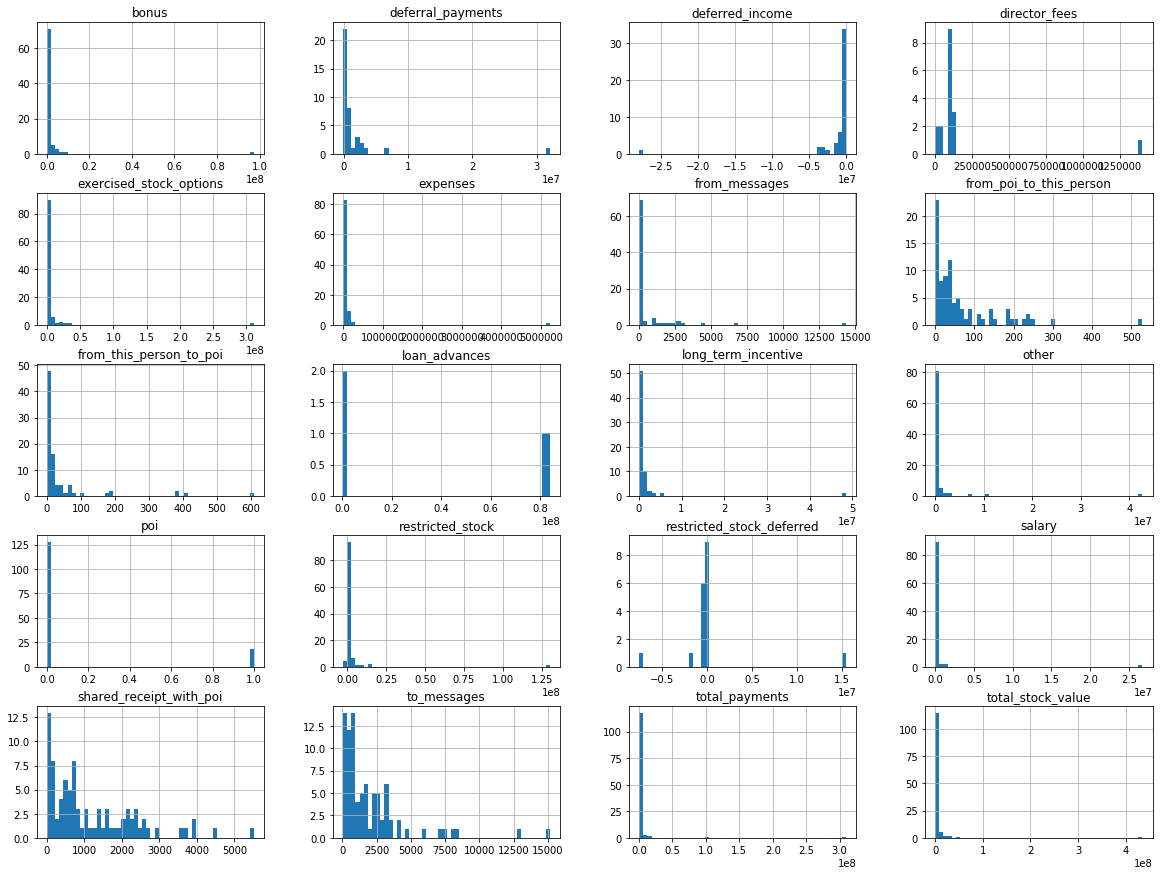

In [42]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Existe um outlier aberrante que esta atrapalhando a visualização dos histogramas. Para identificar o outlier, irei analisar o salário.

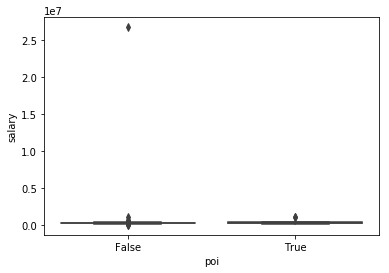

In [53]:
sns.boxplot(x='poi', y='salary', data=df)
plt.show()

Percebemos que o outlier aberrante é um não POI.

In [32]:
df[df['salary'] > 2500000]

,nome,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
130,TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,NaN,311764000.0,5235198.0,NaN,NaN,...,48521928.0,42667589.0,False,130322299.0,-7576788.0,26704229.0,NaN,NaN,309886585.0,434509511.0


 **TOTAL** com certeza não era funcionário da enron. Aqui nos temos um erro na criação do dataset que precisará ser removido para não prejudicar nosso modelo. Por ora, irei remover essa linha para continuar com as análises. 

In [5]:
df_enron = df[df['nome'] != 'TOTAL'].copy(deep=True)

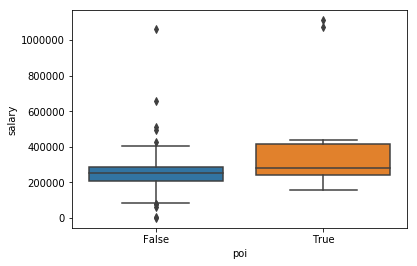

In [52]:
sns.boxplot(x='poi', y='salary', data=df_enron)
plt.show()

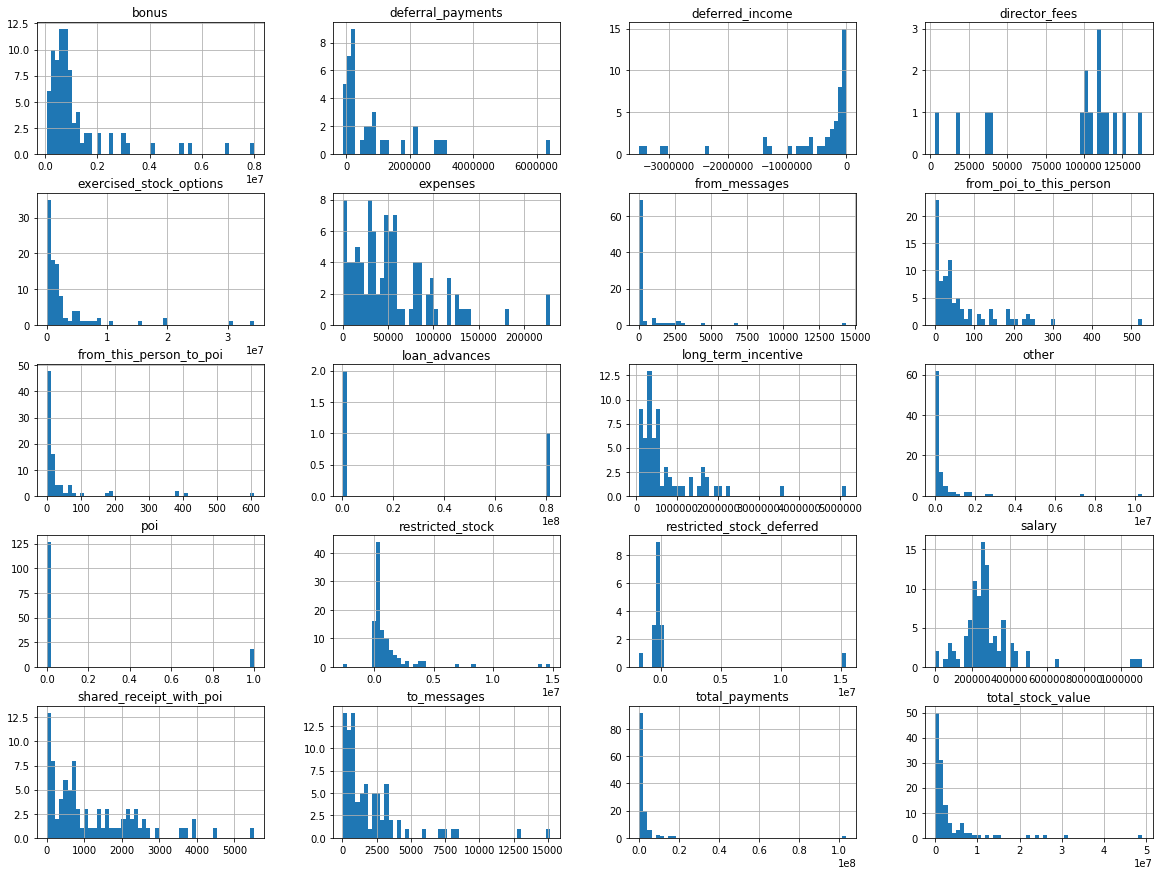

In [48]:
df_enron.hist(bins=50, figsize=(20,15))
plt.show()

Sem o valor aberrante a visualização ficou melhor, mas ainda existem alguns outliers. Percebe-se que temos uma assimetria positiva em quase todos os atributos, dessa maneira, não podemos preencher os valores ausentes com a média, porque estariamos cometendo um erro que afetaria nosso modelo preditivo.

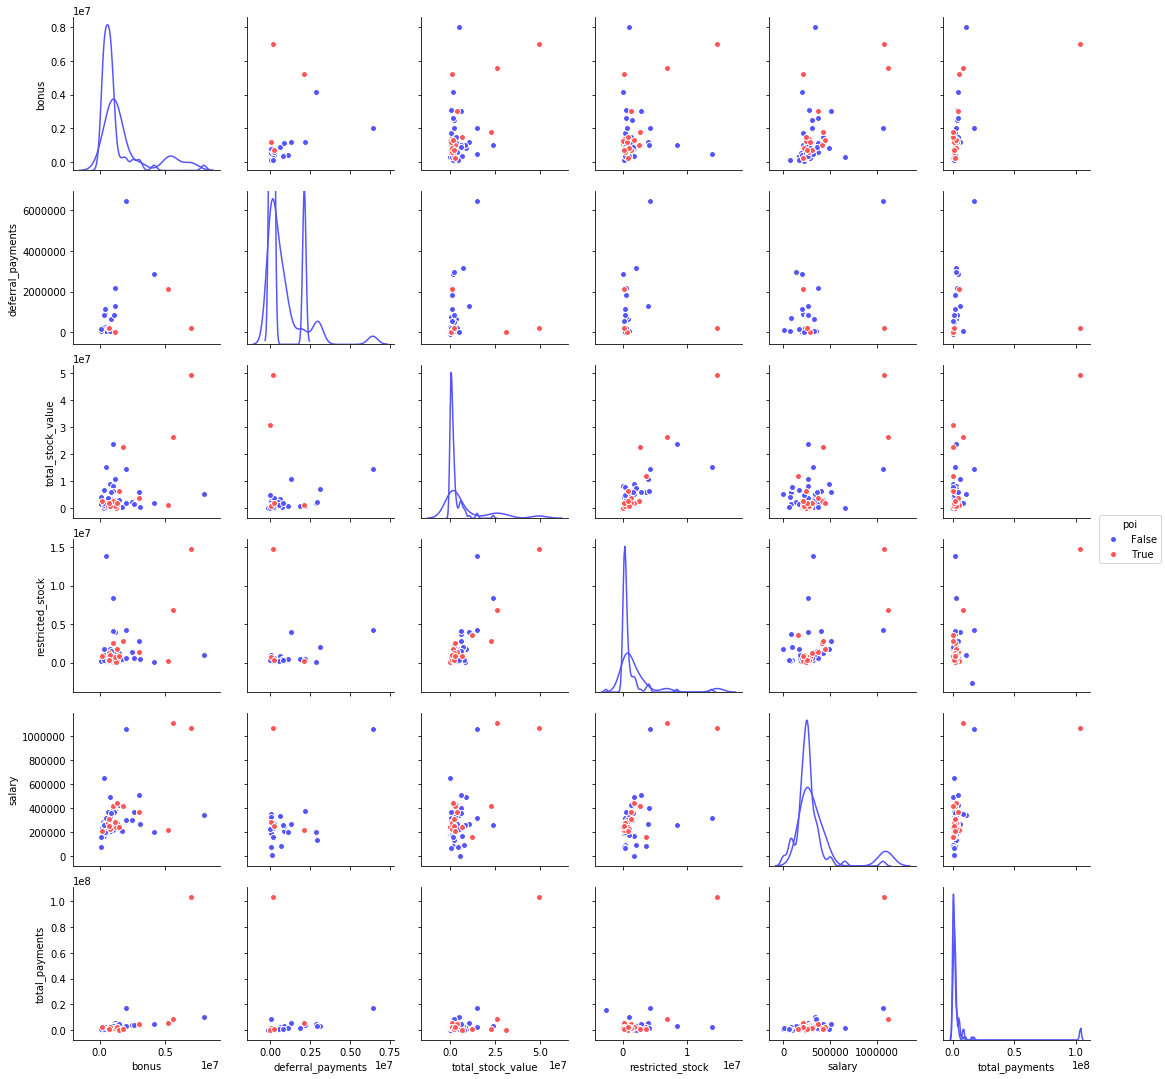

In [6]:
sns.pairplot(df_enron, vars = ['bonus','deferral_payments','total_stock_value','restricted_stock','salary','total_payments'],
                 dropna = True, diag_kind = 'kde', hue = 'poi',palette = 'seismic')
plt.show()

Esperava encontrar alguma correlação forte entre os dados, mas não foi possível identificar nada.

# Fase 2: Preparar os dados

## Fixar ou remover ruídos(outliers).


Na exploração que fiz anteriormente, encontrei três outliers que precisam ser removidos: o primeiro foi a totalização das informações que foi inserida como um funcionário; o segundo foi um funcionário chamado **LOCKHART EUGENE E** que não pussuía informações suficientes; o terceiro foi dados de uma empresa chamada **THE TRAVEL AGENCY IN THE PARK** que foi inserida como funcionário.

In [253]:
def remove_outliers(dictionary):
    """Remove os outliers identificados na EDA.
    
    """
    try:
        del dictionary['TOTAL']
        del dictionary['THE TRAVEL AGENCY IN THE PARK']
        del dictionary['LOCKHART EUGENE E']
    except KeyError:
        print "Outliers ja foram removidos"

## Engenharia de atributos

Para continuar com a investigação, serão criados três atributos que demonstram a fração de mensagens trocadas entre os funcionários e os POIs e um atributo com a renda dos funcionários.

In [254]:
def computeFraction(poi_messages, all_messages):
    """ Calcula a fração de mensagens enviadas e recebidas dos POIs.
    
    Args:
        poi_messages: total de mensagens relacionadas com os POIs
        all_messages: total das mensagens
        
    Returns:
        fração das mensagens.
    """

    fraction = 0.
    if poi_messages != "NaN":
        fraction = float(poi_messages)/float(all_messages)

    return fraction

def compute_income(data_point):
    """Calcula o rendimento do funcionário.
    
    Args:
        data_point: dados de determinado funcionário.
    
    Returns:
        Rendimento de determinado funcionário.
        income = salary + bonus
    """
    salary = 0.
    bonus = 0.
    if data_point['salary'] != "NaN":
        salary = data_point['salary']
    if data_point['bonus'] != "NaN":
        bonus = data_point['bonus']
    return salary + bonus

def create_new_features(dictionary):
    """Cria novas features no dicionário.
    """
    for name in dictionary.keys():
        data_point = dictionary[name]
        #fração de mensagens from_poi
        from_poi_to_this_person = data_point["from_poi_to_this_person"]
        to_messages = data_point["to_messages"]
        fraction_from_poi = computeFraction(from_poi_to_this_person, to_messages)
        dictionary[name]["fraction_from_poi"] = fraction_from_poi
        #fração de mensagens to_poi
        from_this_person_to_poi = data_point["from_this_person_to_poi"]
        from_messages = data_point["from_messages"]
        fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
        dictionary[name]["fraction_to_poi"] = fraction_to_poi
        #income
        dictionary[name]['income'] = compute_income(data_point)

create_new_features(data_dict)

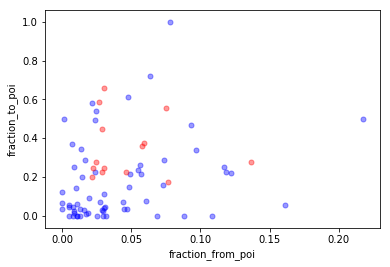

In [255]:
remove_outliers(data_dict)
draw_scatter(data_dict, ['poi', 'fraction_from_poi', 'fraction_to_poi'])

## Preencher valores ausentes

Como temos poucas linhas no dataset, precisamente 143, e alguns outliers, não poderemos utilizar nenhuma medida da tendência central para não enviesar os dados. Dessa forma, os atributos com dados ausentes serão preenchidos com 0.
O atributo "loan_advances" não será incluído na lista devido a baixa quantidade de registros. 

In [256]:
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'income',
                 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
                 'expenses', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock',
                 'director_fees', 'to_messages', 'from_poi_to_this_person','from_messages',
                 'from_this_person_to_poi', 'shared_receipt_with_poi','fraction_from_poi', 
                 'fraction_to_poi']
# a função featureFormat irá preencher com 0 os valores ausentes.
data = featureFormat(data_dict, features_list, remove_all_zeroes = False, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Criando um conjunto de Treinamento e Test

In [257]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

## Seleção de características(atributos)

Para definir quais são as melhores características do meu dataset, irei usar o SelectKBest, onde será feito uma análise de variância para identificar quantas características possui o melhor Score F1.

In [258]:
def select_best_features(n_features):
    """Seleciona as n melhores features de acordo com a variância.
    
    Responsável por selecionar as n melhores features com base 
    na análise de variância.
    
    Args:
        n_features: número de features que deseja
    
    Returns: 
        Lista com o nomes das n features com maior score
        
    """
    data = featureFormat(data_dict, features_list, remove_all_zeroes = False, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    selector = SelectKBest(k = n_features)  
    selector.fit_transform(features, labels)
    selected_indices = selector.get_support(indices=True)
    final_features = []
    for indice in selected_indices:
        #print 'feature -> {} with score -> {}'.format(features_list[indice + 1], selector.scores_[indice])
        final_features.append(features_list[indice + 1])
    return final_features

In [226]:
def selectKBest_f1_scores(clf, dataset, n_kbest_features, folds = 1000):
    """ Verifica os scores do número de features selecionadas.
    
    Responsável por selecionar o score F1 de 2 até n_kbest_features.
    
    Args: 
        clf: classificador utilizado para a análise
        dataset: dados utilizados
        n_kbest_features: número de máximo de features permitido.
        
    Returns:
        retorno1: Lista de valores K
        retorno2: Lista de Scores F1
    """
    graficoX = []
    graficoY = []
    for k in range(2, n_kbest_features):
        features_selected = select_best_features(k)
        features_selected.insert(0, "poi")
        data = featureFormat(dataset, features_selected, sort_keys = True)
        labels, features = targetFeatureSplit(data)
        cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
        true_negatives = 0
        false_negatives = 0
        true_positives = 0
        false_positives = 0
        for train_idx, test_idx in cv: 
            features_train = []
            features_test  = []
            labels_train   = []
            labels_test    = []
            for ii in train_idx:
                features_train.append( features[ii] )
                labels_train.append( labels[ii] )
            for jj in test_idx:
                features_test.append( features[jj] )
                labels_test.append( labels[jj] )

            clf.fit(features_train, labels_train)
            predictions = clf.predict(features_test)
            for prediction, truth in zip(predictions, labels_test):
                if prediction == 0 and truth == 0:
                    true_negatives += 1
                elif prediction == 0 and truth == 1:
                    false_negatives += 1
                elif prediction == 1 and truth == 0:
                    false_positives += 1
                elif prediction == 1 and truth == 1:
                    true_positives += 1
                else:
                    print "Warning: Found a predicted label not == 0 or 1."
                    print "All predictions should take value 0 or 1."
                    print "Evaluating performance for processed predictions:"
                    break
        try:
            f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
            graficoY.append(f1)
            graficoX.append(k)
        except:
            print "Got a divide by zero when trying out:", clf
            print "Precision or recall may be undefined due to a lack of true positive predicitons."
    return  graficoX, graficoY
        

In [243]:
x, y = selectKBest_f1_scores(GaussianNB(), data_dict, 20)

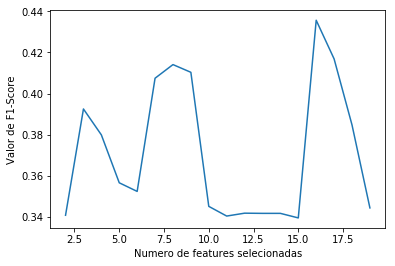

In [244]:
plt.figure()
plt.xlabel("Numero de features selecionadas")
plt.ylabel("Valor de F1-Score")
plt.plot(x, y)
plt.savefig('featureSelection.png', transparent=True)
plt.show()

Como podemos perceber com a visualização acima, com 17 features temos o melhor valor de F1

In [259]:
features_list =  select_best_features(17)
#add POI no ínicio
features_list.insert(0, "poi")

A engenharia de atributos trouxe bons resultados! O atributo "income" teve melhor pontuação que seu criador "salary" e o "fraction_to_poi" também ficou entre os 10 melhores.

# Fase 3: Escolha e Afinamento de um Modelo

## Treinar uma variedade de classificadores


Como estou com um problema de natureza superviosionada, usarei os seguintes algorítmos:
    - DecisionTree
    - RandonForest
    - Adaboost

In [302]:
classifiers = ['adaboost', 'random_forest', 'decision_tree']

### DecisionTree

In [319]:
clf_dc = DecisionTreeClassifier()
t0 = time()
test_classifier(clf_dc, data_dict, features_list, folds = 100)
print("Tempo de ajuste DecisionTree:", round(time()-t0, 3), "s")

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.81400	Precision: 0.29744	Recall: 0.29000	F1: 0.29367	F2: 0.29146
	Total predictions: 1500	True positives:   58	False positives:  137	False negatives:  142	True negatives: 1163

('Tempo de ajuste DecisionTree:', 0.111, 's')


### RandonForest

In [87]:
clf_rf = RandomForestClassifier()
t0 = time()
test_classifier(clf_rf, data_dict, features_list, folds = 100)
print("Tempo de ajuste RandonForest:", round(time()-t0, 3), "s")

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.86467	Precision: 0.48000	Recall: 0.18000	F1: 0.26182	F2: 0.20571
	Total predictions: 1500	True positives:   36	False positives:   39	False negatives:  164	True negatives: 1261

('Tempo de ajuste:', 2.489, 's')


### Adaboost

In [307]:
clf_ab = AdaBoostClassifier()
t0 = time()
test_classifier(clf_ab, data_dict, features_list, folds = 100)
print("Tempo de ajuste Adaboost:", round(time()-t0, 3), "s")

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.84000	Precision: 0.36111	Recall: 0.26000	F1: 0.30233	F2: 0.27542
	Total predictions: 1500	True positives:   52	False positives:   92	False negatives:  148	True negatives: 1208

('Tempo de ajuste Adaboost:', 12.103, 's')


### Modelo Selecionado e Tuning

O modelo mais promissor foi o Adaboost! Para facilitar o processo de tuning, irei automatizar o processo com a construção de uma pipeline, afim de realizar os ajustes necessários para melhorar a precisão e o recall.

In [292]:
def get_classifier_and_param_grid(classifier):
    """Devolve o classificador informado e seu param_grid definido.
    
    Responsável por retornar uma instância do classificador
    especificado e seus parâmetros definidos.
    
    Classificadores definidos: adaboost, random_forest e decision_tree.
    
    Args: 
        classifier: nome do classificador desejado.
        
    Returns:
        return 1: GaussianNB()
        return 2: param_grid
    
    """
    return {
        'adaboost': get_adaboost(),
        'random_forest': get_random_forest_classifier(),
        'decision_tree': get_decision_tree_classifier(),
        'gaussian': get_gaussian_classifier(),
        'knn': get_knn_classifier()
    }.get(classifier)

def get_adaboost():
    """Devolve uma instância do Adaboost e o param_grid definido.
    
    Returns:
        return 1: AdaBoostClassifier()
        return 2: param_grid
    
    """
    decision_tree = []
    for index in range(1, 5):
        decision_tree.append(DecisionTreeClassifier(max_depth=(index), 
                                                    class_weight='balanced',
                                                    min_samples_leaf=2))
    param_grid = {"adaboost__base_estimator": decision_tree,
                  "adaboost__n_estimators": [50],
                  "adaboost__learning_rate": [0.8]
                  }    
    
    return AdaBoostClassifier(), param_grid

def get_random_forest_classifier():
    """Devolve uma instância da RandomForestClassifier e o param_grid definido.
    
    Returns:
        return 1: RandomForestClassifier()
        return 2: param_grid
    
    """
    param_grid = {"random_forest__max_depth": [3, None],
                  "random_forest__max_features": range(1, 5),
                  "random_forest__min_samples_split": [2, 4]
                  }
    
    return RandomForestClassifier(), param_grid

def get_decision_tree_classifier():
    """Devolve uma instância da DecisionTreeClassifier e o param_grid definido.
    
    Returns:
        return 1: DecisionTreeClassifier()
        return 2: param_grid
    
    """
    param_grid = {"decision_tree__max_depth": range(1, 5),
                  "decision_tree__min_samples_leaf": range(1, 5),
                  "decision_tree__min_samples_split": range(2, 5)
                  }
        
    return DecisionTreeClassifier(), param_grid

def get_gaussian_classifier():
    """Devolve uma instância do GaussianNB e o param_grid definido.
    
    Returns:
        return 1: GaussianNB()
        return 2: param_grid
    
    """
    param_grid = {"gaussian__priors": [None]}
        
    return GaussianNB(), param_grid

def get_knn_classifier():
    """Devolve uma instância do GaussianNB e o param_grid definido.
    
    Returns:
        return 1: GaussianNB()
        return 2: param_grid
    
    """
    param_grid = {
                  "knn__algorithm": ('auto', 'ball_tree', 'kd_tree', 'brute'),
                  "knn__leaf_size": range(1, 6),
                  "knn__n_neighbors": range(1, 6)
                 }
        
    return KNeighborsClassifier(), param_grid

In [230]:
def build_pipeline(labels, features, classifier_name):
    """ Constrói uma pipeline com GridSearchCV.
    
    Constrói uma pipeline a fim de obter o melhor ajuste 
    para o classificador informado.
    
    Args: 
        labels: labels de treinamento
        features: features de treinamento
        classifier_name: nome do classificador.
        
    Returns:
        GridSearchCV com as informações da melhor configuração.
    
    """
    # Necessário porque o dataset é pequeno.
    sss = StratifiedShuffleSplit(labels, 100, random_state = 42)
    
    classifier, param_grid = get_classifier_and_param_grid(classifier_name)
    
    pipeline  = Pipeline([
                         ('scaler',  MinMaxScaler()),
                         ('feature_selection', SelectKBest(k = 17)),
                         (classifier_name, classifier),
                        ])

    grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1', cv = sss)

    grid_search.fit(features, labels)

    return grid_search

In [293]:
def performance_classifiers(classifiers_names):
    """ Constrói um dicionário com o melhor ajuste para cada classificador.
    
    Responsável por construir um dicionário com todos os classificadores
    informados como chave e os melhores ajustes encontrado no GridSearch
    como valor.
    
    Args:
        classifiers_names: lista com os nomes dos classificadores.
        
    Returns:
        Dicionário com o nome do classificador como key e o melhor
        ajuste como valor
    
    """
    performance_clasifiers = {}
    for name in classifiers_names:
        performance_clasifiers[name] = build_pipeline(labels_train, features_train, name)
    return performance_clasifiers


In [294]:
dict_cv_by_classifier =  performance_classifiers(classifiers)

In [16]:
clf = dict_cv_by_classifier['random_forest']
test_classifier(clf.best_estimator_, data_dict, features_list)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C7D1668>)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2,...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.86040	Precision: 0.44835	Recall: 0.20400	F1: 0.28041	F2: 0.22896
	Total predictions: 15000	True positives:  408	False positives:  502	False negatives: 1592	True negatives: 12498



###  Resultados da Adaboost ajustada

In [299]:
clf = dict_cv_by_classifier['adaboost']
test_classifier(clf.best_estimator_, data_dict, features_list)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=17, score_func=<function f_classif at 0x000000000C7D1668>)), ('adaboost', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='...ne,
            splitter='best'),
          learning_rate=0.8, n_estimators=50, random_state=None))])
	Accuracy: 0.82220	Precision: 0.33266	Recall: 0.33150	F1: 0.33208	F2: 0.33173
	Total predictions: 15000	True positives:  663	False positives: 1330	False negatives: 1337	True negatives: 11670



In [300]:
dump_classifier_and_data(clf, data_dict, features_list)

In [ ]:
%run "tester.py"

# Referências

 - https://seaborn.pydata.org/examples/distplot_options.html
 - https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
 - https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
 - https://stackoverflow.com/questions/60208/replacements-for-switch-statement-in-python
